## Segmentation Toy Example

In [1]:
import tensorflow as tf
import numpy as np
import helper
from PIL import Image
import tensorflow.contrib.slim as slim
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
image = np.array(Image.open("./train.png"))
label = np.array(Image.open("./label.png"))

In [3]:
image.shape

(360, 480, 3)

In [4]:
label.shape

(360, 480)

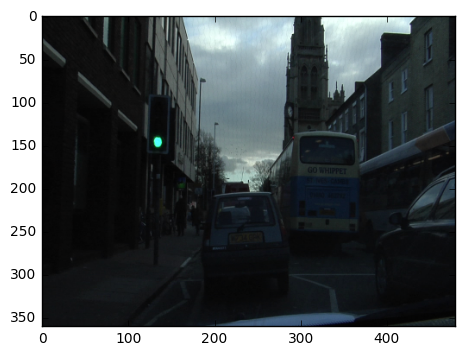

In [5]:
plt.imshow(image)

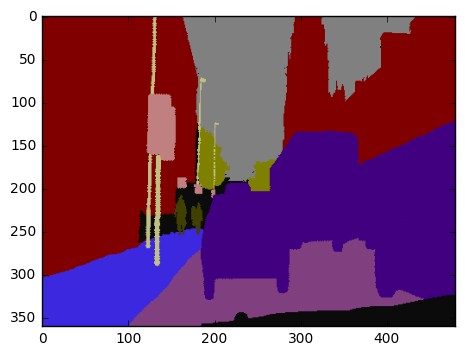

In [6]:
plt.imshow(helper.showLabel(label))

## Building The Model
We use simple conv layers to construct our encoder and corresponding deconv to upsample to original resolution.

In [7]:
image_input = tf.placeholder(tf.float32, shape=(1, 360, 480, 3))
label_input = tf.placeholder(tf.int32, shape=(1, 360, 480, 1))
is_training =tf.placeholder(tf.bool) # control batch-norm
# Assume batch_size = 1

In [8]:
with slim.arg_scope([slim.conv2d],
                    activation_fn=tf.nn.relu,
                    normalizer_fn=slim.batch_norm,
                    normalizer_params={'is_training': is_training},
                    weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                    weights_regularizer=slim.l2_regularizer(0.0005)):
    repeat_time = 2
    channel = 64
    net = slim.repeat(image_input, repeat_time, slim.conv2d, channel, [3, 3], scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1') # => 180 X 240
    net = slim.repeat(net, repeat_time, slim.conv2d, channel, [3, 3], scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2') #  => 90 X 120
    net = slim.repeat(net, repeat_time, slim.conv2d, channel, [3, 3], scope='conv3')
    net = slim.max_pool2d(net, [2, 2], scope='pool3') # => 45 X 60
    net = slim.conv2d(net, channel, [3, 3], scope='conv4')
    # decoder
    net = slim.conv2d_transpose(net, channel, [3, 3], [2, 2], scope='deconv1') # => 90 X 120
    net = slim.repeat(net, 2, slim.conv2d, channel, [3, 3], scope='conv6')
    net = slim.conv2d_transpose(net, channel, [3, 3], [2, 2], scope='deconv2') # => 180 X 240
    net = slim.repeat(net, 2, slim.conv2d, channel, [3, 3], scope='conv7')
    net = slim.conv2d_transpose(net, channel, [3, 3], [2, 2], scope='deconv3') # => 240 X 480
    net = slim.repeat(net, 2, slim.conv2d, channel, [3, 3], scope='conv8')
    # classification layer
    net = slim.conv2d(net, 11, [1, 1], activation_fn=None, scope='classification')
    logits = tf.argmax(net, axis=3)
    

In [9]:
net.get_shape().as_list()

[1, 360, 480, 11]

## Loss Function
We use cross-entropy function as our loss function.

In [10]:
labels = tf.one_hot(label_input, depth=11)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=net, 
                                              labels=labels,
                                              name="loss")
loss = tf.reduce_mean(loss)

In [11]:
train_op = tf.train.AdamOptimizer().minimize(loss)

## Main Loop

step = 0, loss = 2.614619 
step = 100, loss = 1.322374 
step = 200, loss = 0.780259 
step = 300, loss = 0.613066 
step = 400, loss = 0.604036 


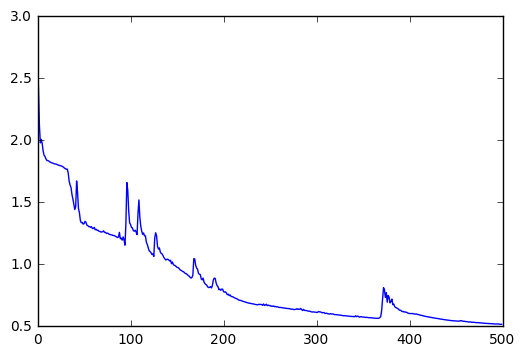

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# We only use 1 sample image in this demo...
loss_history = []
for step in range(500):
    _, _loss = sess.run([train_op, loss], 
                       feed_dict={
                            image_input: image[np.newaxis, ...].astype(np.float32),
                            label_input: label[np.newaxis, ..., np.newaxis].astype(np.int32),
                            is_training: True
                        })
    loss_history.append(_loss)
    if step % 100 == 0:
        print("step = %d, loss = %f "%(step, _loss))
plt.plot(loss_history)

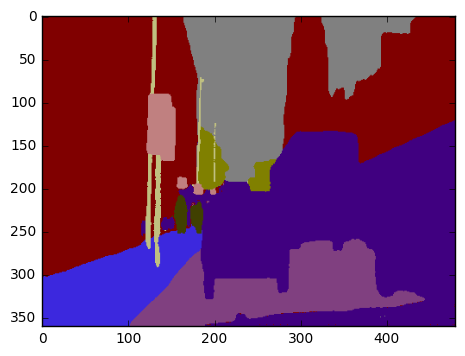

In [13]:
pred = sess.run(logits, feed_dict={
        image_input: image[np.newaxis, ...].astype(np.float32),
        label_input: label[np.newaxis, ..., np.newaxis].astype(np.int32),
        # because only one example and 500 iter, batch-norm param haven't warm up
        # so we use batch-norm training stats here....
        # In real exmaple, you should use is_training=False in testing phase.
        is_training: True
})
# show loss and prediction
pred = helper.showLabel(pred[0])
plt.imshow(pred)